In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftn, ifftn, fftfreq, fftshift
from scipy.stats import binned_statistic
from matplotlib.backends.backend_pdf import PdfPages
import glob
import athena_read
import h5py

In [3]:
def read_npy(paths,sep=2):
    npys = []
    paths = [p for p in glob.glob(paths)]
    #print(paths)
    for i,path in enumerate(paths):
        npys.append(np.load(path))
        if i % sep == 0:
            print(f'{i}:Loading {path} {npys[-1].shape}')
    print(f'Total of {len(npys)} files loaded')
    return npys

In [4]:
def read_athdf(paths,sep=2):
    athdfs = []
    paths = [p for p in glob.glob(paths)]
    for i, path in enumerate(paths):
        athdfs.append(athena_read.athdf(path))
        if i % sep == 0:
            print(f'{i}:Loading {path}')
    print(f'Total of {len(athdfs)} files loaded')
    return athdfs

In [5]:
def read_athdf_fields(paths, field_names):
    if isinstance(field_names,str):
        field_names = [field_names]
    athdfs = read_athdf(paths)
    athdf_fields = []
    for athdf in athdfs:
        fields = [athdf[field] for field in field_names]
        athdf_fields.append(np.stack(fields))
    del athdfs
    return athdf_fields

In [6]:
#normal = read_athdf('../athenaMLdata/data/*')

In [74]:
vg_normal = read_athdf_fields('../athenaMLdata/data/*',['vel1','vel2','vel3'])[2]
vg_kdrive = read_athdf_fields('../athenaMLdata/data_kdrive3-8/*',['vel1','vel2','vel3'])[4]
#vg_dedt54 = read_athdf_fields('../athenaMLdata/data_dedt5e-4/*',['vel1','vel2','vel3'])

0:Loading ../athenaMLdata/data/TurbPar.out2.00101.athdf
2:Loading ../athenaMLdata/data/TurbPar.out2.00103.athdf
4:Loading ../athenaMLdata/data/TurbPar.out2.00105.athdf
Total of 5 files loaded
0:Loading ../athenaMLdata/data_kdrive3-8/TurbPar.out2.00008.athdf
2:Loading ../athenaMLdata/data_kdrive3-8/TurbPar.out2.00010.athdf
4:Loading ../athenaMLdata/data_kdrive3-8/TurbPar.out2.00012.athdf
Total of 5 files loaded


In [8]:
ls -la ../athenaMLdata//

total 0
drwxrwxrwx 1 ymchan ymchan 4096 Jul 23  2023 ./
drwxrwxrwx 1 ymchan ymchan 4096 Jul 23  2023 ../
drwxrwxrwx 1 ymchan ymchan 4096 Jul 23  2023 data/
drwxrwxrwx 1 ymchan ymchan 4096 Jul 23  2023 data_dedt5e-4/
drwxrwxrwx 1 ymchan ymchan 4096 Jul 23  2023 data_kdrive3-8/
drwxrwxrwx 1 ymchan ymchan 4096 Jul 23  2023 data_ts0.001/


In [36]:
#vg_normal = read_npy(['/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vel.npy'])[0]
#vg_kdrive = read_npy(['/mnt/home/tchan1/ceph/mldust-ver2/data/npy-kdrive3-8/TurbPar.out2.00010.hdf5-vp.npy'])[0]

In [40]:
vg_normal = read_npy('../power-spectrum-data/TurbPar.out2.00010.hdf5-vp.npy')[0]
vg_kdrive = read_npy('../power-spectrum-data/kdrive3-8file.npy')[0]

0:Loading ../power-spectrum-data/TurbPar.out2.00010.hdf5-vp.npy (3, 256, 256, 256)
Total of 1 files loaded
0:Loading ../power-spectrum-data/kdrive3-8file.npy (3, 256, 256, 256)
Total of 1 files loaded


In [10]:
dx = 1/256
dV = dx*dx*dx

In [11]:
vg_normal.shape,vg_kdrive.shape

((3, 256, 256, 256), (3, 256, 256, 256))

In [12]:
np.sum(vg_normal**2)*dV, np.sum(vg_kdrive**2)*dV

(0.03235923498868942, 0.015369369648396969)

In [49]:
def power_spec(vg):
    freq = fftfreq(256,1/256)
    fx,fy,fz = np.meshgrid(freq,freq,freq)
    f = np.sqrt(fx**2 + fy**2 + fz**2)
    freqBins = np.geomspace(np.min(f)+0.5,np.max(f),22+1)
    powers = []
    #raw_powers = []
    for i in range(3):
        spectrum = fftn(vg[i])*dV
        spectrum = np.real(spectrum*np.conjugate(spectrum))
        powers.append(spectrum)
        #raw_powers.append(spectrum)
    
    powers = np.stack(powers)
    print(powers.shape)
    powers = np.sum(powers, axis=0)
    print(powers.shape)
    print('Total power before binning: ',np.sum(powers))
    powers, binEdges, _ = binned_statistic(f.flatten(),powers.flatten(), statistic='sum',bins=freqBins)
        
    binCenters = np.sqrt(binEdges[1:]*binEdges[:-1])
    print('Total powre after binning: ',np.sum(powers*(binEdges[1:]-binEdges[:-1])))
    return {'freqCenters':binCenters, 'power':powers, 'freqEdges':binEdges}

In [71]:
normal_spec =  power_spec(vg_normal)

(3, 256, 256, 256)
(256, 256, 256)
Total power before binning:  0.02383470403913161
Total powre after binning:  0.08811978769538173


In [72]:
kdrive_spec = power_spec(vg_kdrive)

(3, 256, 256, 256)
(256, 256, 256)
Total power before binning:  0.012194105631137618
Total powre after binning:  0.05280834777568258


In [66]:
#freqCenter.shape, power.shape, freqEdges.shape

In [67]:
#np.sum(freqCenter*power*(freqEdges[1:]-freqEdges[:-1]))

In [68]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

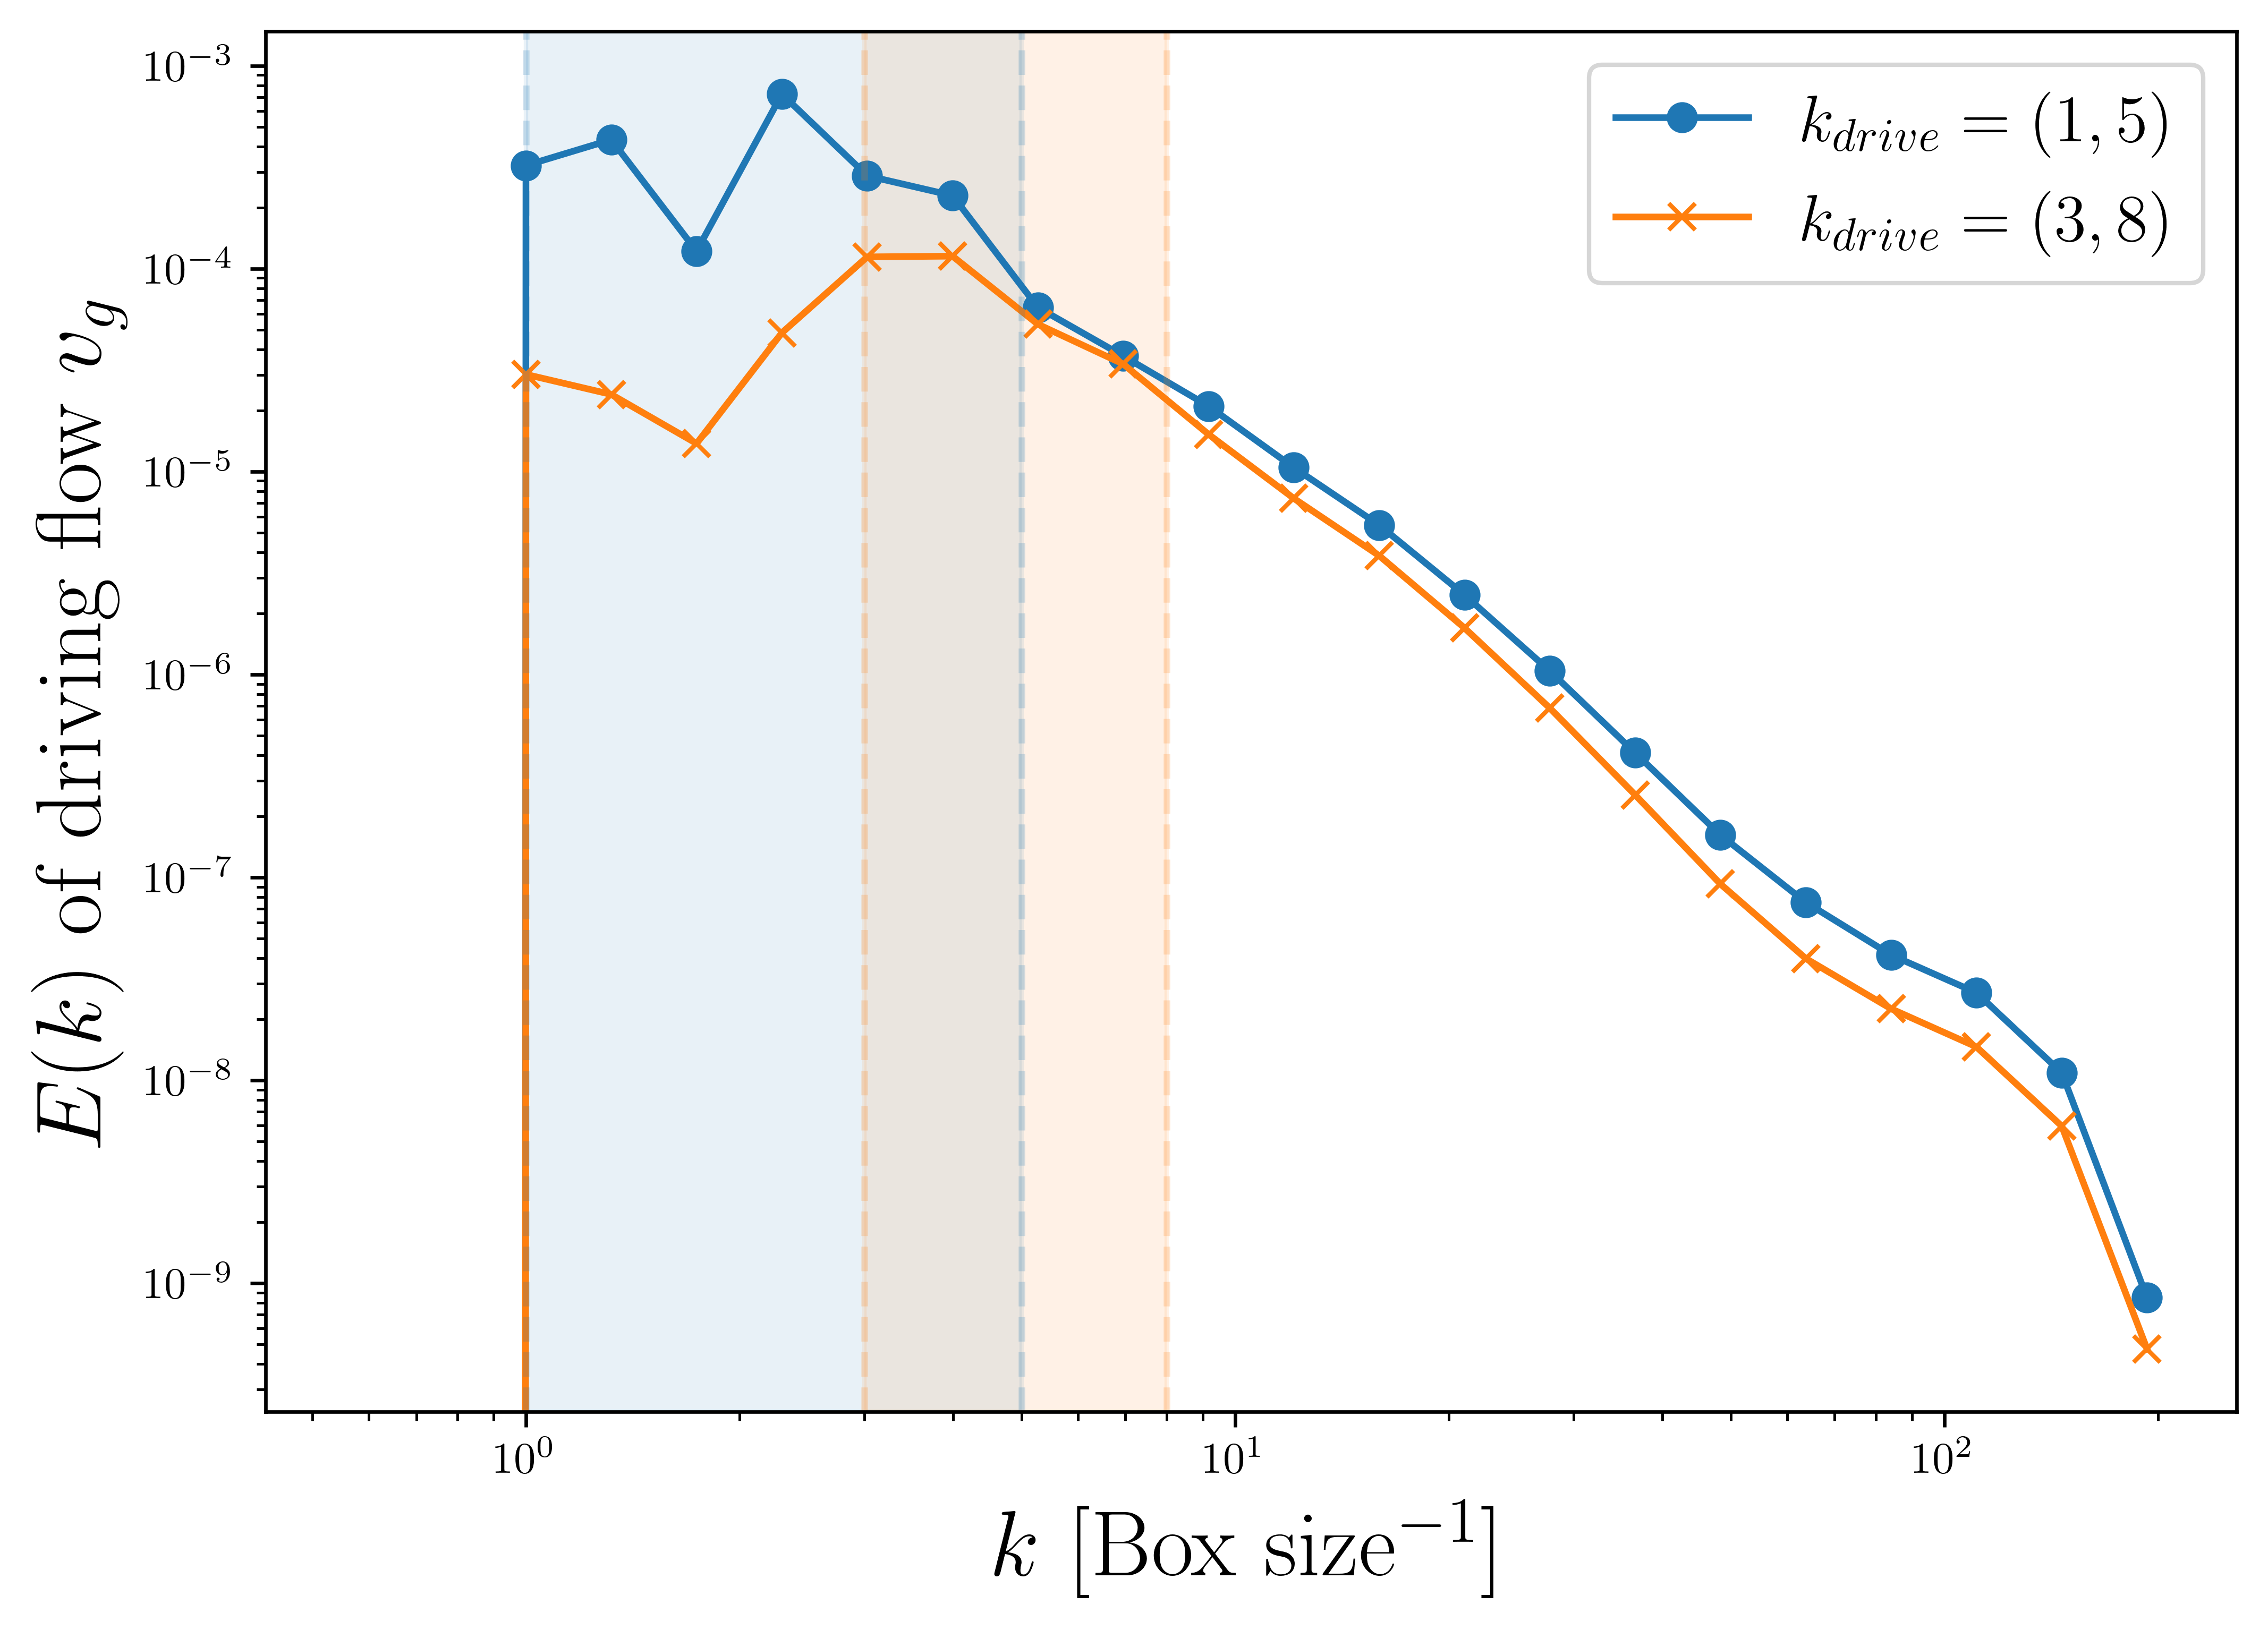

In [73]:
#with PdfPages('vg_power_spectrum.pdf') as pdf:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(7,5),dpi=600,constrained_layout=True)

axs.loglog(normal_spec['freqCenters'],normal_spec['power']/normal_spec['freqCenters']**2,ls='-',marker='o',label=r'$k_{drive}=(1,5)$')
axs.loglog(kdrive_spec['freqCenters'],kdrive_spec['power']/kdrive_spec['freqCenters']**2,ls='-',marker='x',label=r'$k_{drive}=(3,8)$')
axs.set_xlabel(r'$k$ [Box size$^{-1}$]',fontsize=21)
axs.set_ylabel(r'$E(k)$ of driving flow $v_g$',fontsize=21)
axs.axvline(1,color='tab:blue',ls='--',alpha=0.2)
axs.axvline(5,color='tab:blue',ls='--',alpha=0.2)

axs.axvline(3,color='tab:orange',ls='--',alpha=0.2)
axs.axvline(8,color='tab:orange',ls='--',alpha=0.2)

#axs.set_title(r'Energy spectrum of $v_g$',fontsize=21)

yl,yh = plt.gca().get_ylim()
axs.set_ylim(yl,yh)

x15 = np.linspace(1,5)
x38 = np.linspace(3,8)
axs.fill_between(x15,yl,yh,color='tab:blue',alpha=0.1)
axs.fill_between(x38,yl,yh,color='tab:orange',alpha=0.1)
#axs.xaxis.set_minor_locator(mticker.LogLocator(subs="auto"))
axs.legend(fontsize=15)
#axs.minorticks_on()
#axs.grid(which='minor')
    #pdf.savefig(fig)

# 